In [1]:
import os

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib nbagg


# Directory with unzipped copy of GovTrack's US congress data
# https://data.world/govtrack/us-congress-legislators
DATA_DIR = os.path.join(os.getcwd(), 'govtrack-us-congress-legislators')

In [2]:
df_legislators = pd.concat([
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-historical.csv')),
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-current.csv')),
], axis=0, sort=False)

df_legislators.birthday_bio = pd.to_datetime(df_legislators.birthday_bio)

In [3]:
df_terms = pd.concat([
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-historical-terms.csv'), low_memory=False),
    pd.read_csv(os.path.join(DATA_DIR, 'legislators-current-terms.csv'), low_memory=False),
], axis=0, sort=False).set_index('bioguide')

df_terms.start = pd.to_datetime(df_terms.start)
df_terms.end = pd.to_datetime(df_terms.end)

In [4]:
df_full = pd.merge(
    df_terms, df_legislators,
    how='left', left_on='bioguide', right_on='bioguide_id'
)

is_missing_dt = pd.concat([
    df_full.birthday_bio.isnull(),
    df_full.start.isnull(),
    df_full.end.isnull()
], axis=1).any(axis=1)

# There are some mystery-terms that link to people born well after they started...
is_bad_age = ((df_full.start - df_full.birthday_bio).dt.days // 365) < 25

df_full = df_full[~is_missing_dt & ~is_bad_age]

In [5]:
date_age_pairs = []
for _, bio_row in df_full.iterrows():
    date_span = pd.date_range(bio_row.start, bio_row.end, closed='left', freq='365D')
    for date in date_span:
        if date < pd.datetime.now():
            age = (date - bio_row.birthday_bio).days // 365
            date_age_pairs.append((date, age, bio_row.type))

df_ages = pd.DataFrame(
    date_age_pairs,
    columns=['date', 'age', 'type']
)

df_ages['year'] = df_ages.date.dt.year

In [6]:
avg_age = df_ages.groupby(['type', 'year'])['age'].median()

/Users/mcmenamin/.virtualenvs/py3env/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


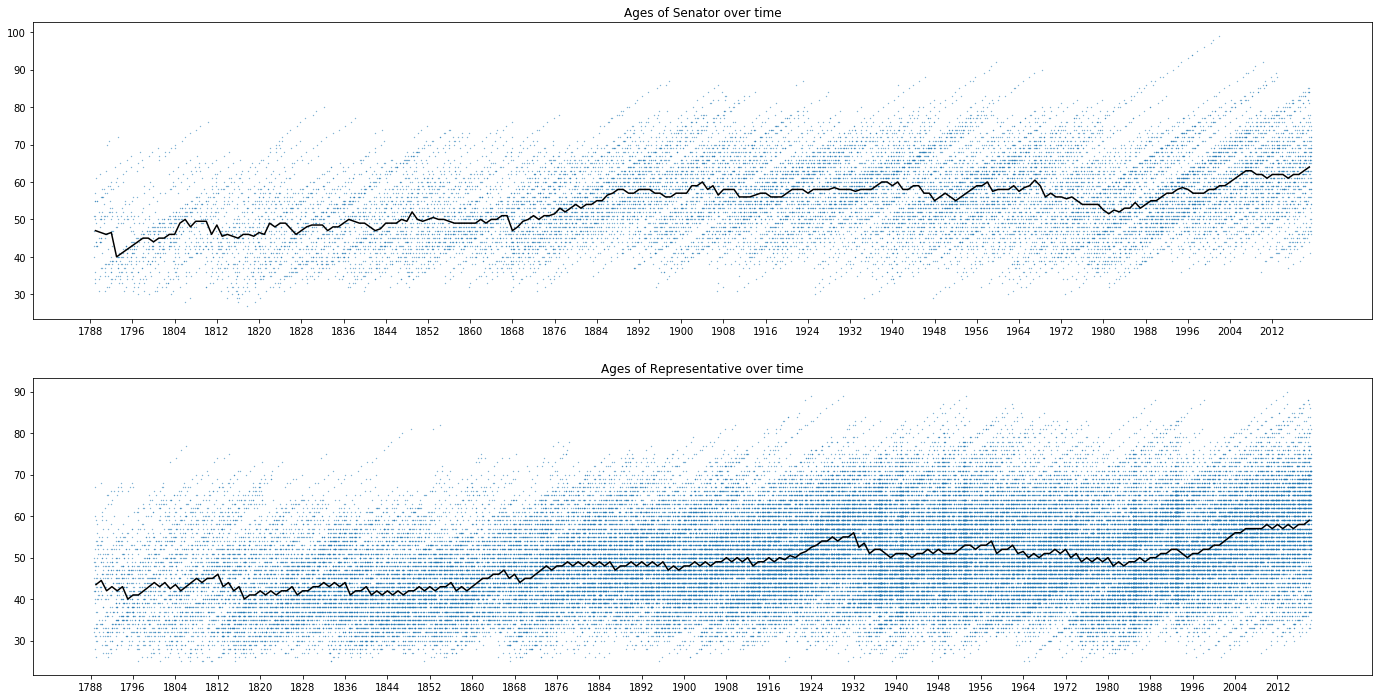

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 12))

scatter_kwargs = {
    'alpha': 0.8,
    's': 0.1
}
line_args = ['-k']

cong_types = {
    'sen': 'Senator',
    'rep': 'Representative'
}


for ax, (cong_type, full_cong_type) in zip(axes, cong_types.items()):
    ax.set_title('Ages of {} over time'.format(full_cong_type))

    _df_ages = df_ages[df_ages.type == cong_type]
    jitter = 0.8 * (pd.np.random.random(len(_df_ages),) - 0.5)
    _df_ages.year += jitter

    _avg_age = avg_age.loc[cong_type]

    ax.scatter(_df_ages.year, _df_ages.age, **scatter_kwargs)
    ax.plot(_avg_age.index, _avg_age.values, *line_args)
    ax.set_xticks(range(1788, 2016, 8))

fig.savefig('congressional_ages_over_time.png')